In [1]:
# !pip install xgboost

# Compétition régression data science Salaire

L'import des librairies et dépendances 

In [49]:
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor,GradientBoostingRegressor
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import tflearn
import tensorflow as tf
import seaborn
import warnings
warnings.filterwarnings('ignore')

from subprocess import check_output
import pandas as pd

# Import des librairies permettant de faire de la features enginneering
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
label_encod = LabelEncoder()

L'import et la lecture des données provenant d'un fichier csv en utilisant la fonction de pandas "read_csv" 

In [52]:
df = pd.read_csv('ds_salaries.csv')

In [4]:
df

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...,...,...,...
602,602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M


In [5]:
df=df.drop(['Unnamed: 0'], axis=1)

Vérification des valeur null dans la dataset

In [6]:
df.isna().sum()/607

work_year             0.0
experience_level      0.0
employment_type       0.0
job_title             0.0
salary                0.0
salary_currency       0.0
salary_in_usd         0.0
employee_residence    0.0
remote_ratio          0.0
company_location      0.0
company_size          0.0
dtype: float64

# Analyse Exploratoire

## Data Visualisation

In [41]:
# Récuperation d'information concernant la data set
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   work_year           597 non-null    int64
 1   experience_level    597 non-null    int64
 2   employment_type     597 non-null    int64
 3   job_title           597 non-null    int64
 4   salary              597 non-null    int64
 5   salary_currency     597 non-null    int64
 6   salary_in_usd       597 non-null    int64
 7   employee_residence  597 non-null    int64
 8   remote_ratio        597 non-null    int64
 9   company_location    597 non-null    int64
 10  company_size        597 non-null    int64
dtypes: int64(11)
memory usage: 56.0 KB


<AxesSubplot:>

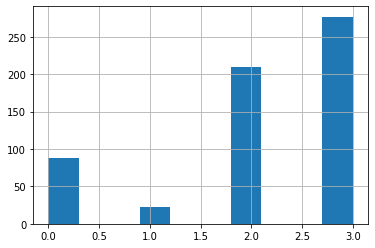

In [42]:
# Visualisation en histogramme des niveaux d'expériences 
df.experience_level.hist() 

<AxesSubplot:>

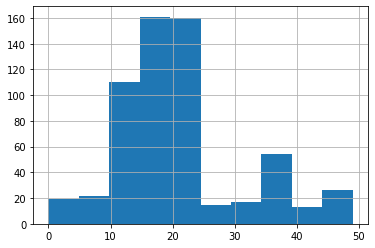

In [43]:
# Visualisation en histogramme des titres de poste
df.job_title.hist() 

<AxesSubplot:>

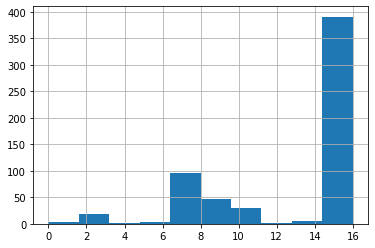

In [44]:
# Visualisation en histogramme des differentes monnaies de salaires
df.salary_currency.hist() 

<AxesSubplot:>

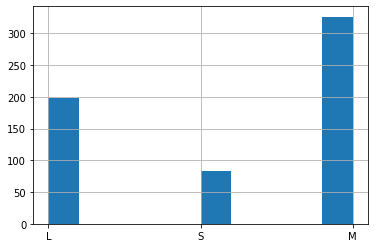

In [11]:
#  Visualisation en histogramme des differentes Tailles des entreprises
df.company_size.hist() 

<AxesSubplot:>

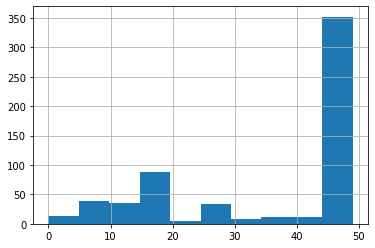

In [45]:
#  Visualisation en histogramme des differente localisations des entreprises
df.company_location.hist() 

La visualisation des différents postes existants est leur fréquence de présence

In [13]:
most_jobs = df.groupby(['job_title']).size().to_frame().sort_values([0], ascending= False).head(6).reset_index()
most_jobs =most_jobs.rename(columns={0:'count'}) 

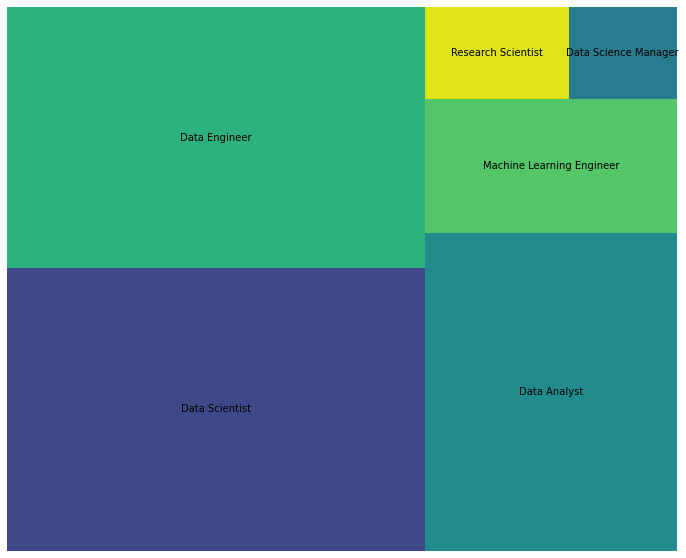

In [14]:

import squarify
sizes = list(most_jobs['count'])
label = list(most_jobs['job_title'])
plt.figure(figsize=(12,10))
squarify.plot(sizes=sizes, label=label)
plt.axis('off')
plt.show()


# Features engineering

L'encodage des variables qualitatives permet de transformer des mots en chiffres ou nombre

In [53]:
# L'encodage des variable qualitatives

df['experience_level'] = label_encod.fit_transform(df['experience_level'])
df['employment_type'] =label_encod.fit_transform(df['employment_type'])
df['job_title'] =label_encod.fit_transform(df['job_title'])
df['salary_currency'] =label_encod.fit_transform(df['salary_currency'])
df['employee_residence'] =label_encod.fit_transform(df['employee_residence'])
df['company_location'] =label_encod.fit_transform(df['company_location'])
df['company_size'] = label_encod.fit_transform(df['company_size'])


Après la phase d'encodage, la visualisation des données aberrantes sur la colonne des salaire USD grace a la fonction de Boxplot de matplotlib

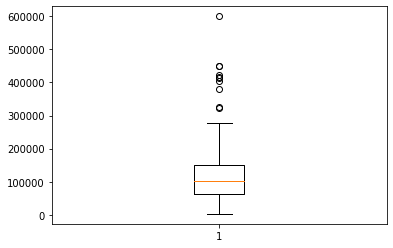

In [54]:
# Visualisation des données aparametresberrantes
plt.boxplot(df['salary_in_usd'])
# show plot
plt.show()

Étant donné que les données aberrantes existent, j'ai fais une suppression

In [55]:
mini = df['salary_in_usd'].quantile(0.25)
maxi = df['salary_in_usd'].quantile(0.75)
IQR = maxi - mini    #IQR is interquartile range. 
filter = (df['salary_in_usd'] >= mini - 1.5 * IQR) & (df['salary_in_usd'] <= maxi + 1.5 *IQR)
df =df.loc[filter] 

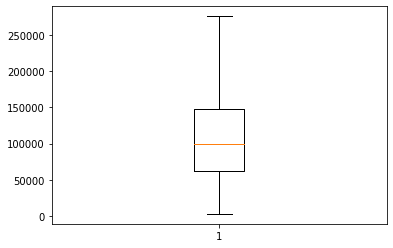

In [56]:
# Visualisation des données aberrantes
plt.boxplot(df['salary_in_usd'])
# show plot
plt.show()

In [20]:
import numpy as np
X = np.array(df.loc[:,~df.columns.isin(['salary','salary_in_usd', 'salary_currency'])])
y = np.array(df['salary_in_usd'])


La phase de normalisation permet de mettre sur la même échelle 

In [21]:
#La standardisation des features
scaler = StandardScaler()
x_scaler = scaler.fit_transform(X)

In [22]:
#Division de la data set
x_train, x_val, y_train, y_val = train_test_split(x_scaler, y, test_size = 0.20, shuffle = True)


# Recherche de modele de regression 

## Gridsearch de modèle

8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8


,R Square Score
Linear,0.346417
Ridge,0.346619
Bayesian Ridge,0.348514
Hubber,0.348095
Lasso,0.346417
Bagging,0.484419
RandomForest,0.512608
G-boost,0.538766
AdaBoost,0.419454
SVM RBF,-0.022900


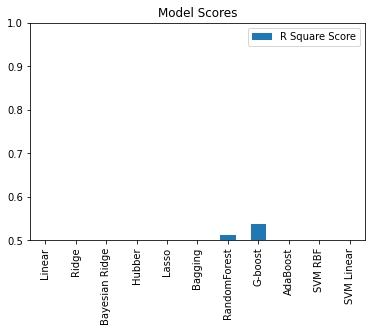

In [23]:

# Recherche du modeles le plus performant
# train = X_pca
# labels =Y_pca

def lets_try(train,labels):
    results={}
    def test_model(clf):
        
        cv = KFold(n_splits=5,shuffle=True,random_state=45)
        r2 = make_scorer(r2_score)
        r2_val_score = cross_val_score(clf, train, labels, cv=cv,scoring=r2)
        scores=[r2_val_score.mean()]
        
        return scores

    clf = linear_model.LinearRegression()
    results["Linear"]=test_model(clf)
    
    clf = linear_model.Ridge()
    results["Ridge"]=test_model(clf)
    
    clf = linear_model.BayesianRidge()
    results["Bayesian Ridge"]=test_model(clf)
    
    clf = linear_model.HuberRegressor()
    results["Hubber"]=test_model(clf)
    
    clf = linear_model.Lasso(alpha=1e-4)
    results["Lasso"]=test_model(clf)
    
    clf = BaggingRegressor()
    results["Bagging"]=test_model(clf)
    
    clf = RandomForestRegressor()
    results["RandomForest"]=test_model(clf)
    
    clf = GradientBoostingRegressor()
    results["G-boost"]=test_model(clf)
    
    clf = AdaBoostRegressor()
    results["AdaBoost"]=test_model(clf)
    
    clf = svm.SVR()
    results["SVM RBF"]=test_model(clf)
    
    clf = svm.SVR(kernel="linear")
    results["SVM Linear"]=test_model(clf)
    
    results = pd.DataFrame.from_dict(results,orient='index')
    results.columns=["R Square Score"] 
#     results=results.sort_values(columns=["R Square Score"],ascending=False, inplace=True)
    results.plot(kind="bar",title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([0.5,1])
    return results

lets_try(x_train,y_train)

In [24]:
regr = GradientBoostingRegressor(random_state=0)
regr.fit(x_train, y_train)

GradientBoostingRegressor(random_state=0)

In [25]:
prediction_1 = regr.predict(x_val)

8


In [26]:
from sklearn.metrics import make_scorer,max_error, mean_absolute_error, mean_squared_error,accuracy_score


In [27]:
max_err_1 = max_error(y_val, prediction_1)
mean_err_1 = mean_absolute_error(y_val, prediction_1)
mean_squ_1 = mean_squared_error(y_val, prediction_1)
score_1 = r2_score(y_val, prediction_1)
print("error max:",max_err_1 )
print('Mean Absolute error :',mean_err_1)
print('Mean Squared error :',mean_squ_1)
print('R2 score :',score_1)

error max: 127462.21405939516
Mean Absolute error : 29311.329613448477
Mean Squared error : 1419832342.1280992
R2 score : 0.5534608750528454


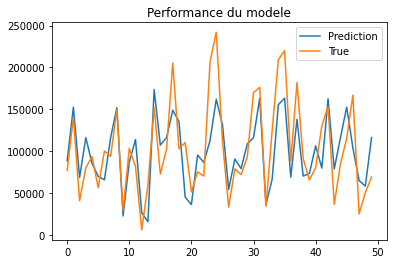

In [28]:
plt.title('Performance du modele')
plt.plot(list(prediction_1)[:50], label = 'Prediction')
plt.plot(list(y_val)[:50], label = 'True')
plt.legend()

##  Recherche des paramètres

In [33]:
# Creation de la grid des parametres
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators':[500,1000,2000],'learning_rate':[.001,0.01,.1],'max_depth':[1,2,4],'subsample':[.5,.75,1],'random_state':[1]}
# Create a based model
Gb = GradientBoostingRegressor(
    
)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=Gb,param_grid=param_grid,scoring='neg_mean_squared_error',n_jobs=1,cv=5)

In [34]:
grid_search.fit(x_train, y_train)
# meilleur_gri = grid_search.best_params_

8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8


In [36]:
meilleur_gri2 = grid_search.best_estimator_
prediction_2 = meilleur_gri2.predict(x_val)

8


In [51]:
best_params= grid_search.best_params_
print('Les meilleurs paramètres :', best_params)

Les meilleurs paramètres : {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 2000, 'random_state': 1, 'subsample': 0.75}


In [37]:
max_err_2 = max_error(y_val, prediction_2)
mean_err_2 = mean_absolute_error(y_val, prediction_2)
mean_squ_2 = mean_squared_error(y_val, prediction_2)
score_2 = r2_score(y_val, prediction_2)
print("error max:",max_err_2 )
print('Mean Absolute error :',mean_err_2)
print('Mean Squared error :',mean_squ_2)
print('R2 score :',score_2)

error max: 128119.34806896796
Mean Absolute error : 28655.177899715844
Mean Squared error : 1364256857.6192203
R2 score : 0.5709394374751613


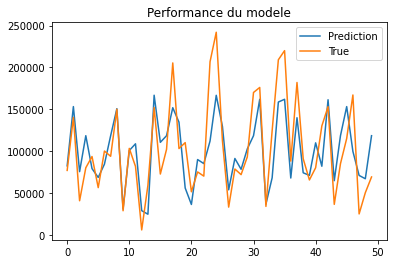

In [38]:
plt.title('Performance du modele')
plt.plot(list(prediction_2)[:50], label = 'Prediction')
plt.plot(list(y_val)[:50], label = 'True')
plt.legend()

In [39]:
prediction_3=grid_search.predict(x_val)

8


In [40]:
max_err_3 = max_error(y_val, prediction_3)
mean_err_3 = mean_absolute_error(y_val, prediction_3)
mean_squ_3 = mean_squared_error(y_val, prediction_3)
score_3 = r2_score(y_val, prediction_3)
print("error max:",max_err_3 )
print('Mean Absolute error :',mean_err_3)
print('Mean Squared error :',mean_squ_3)
print('R2 score :',score_3)

error max: 128119.34806896796
Mean Absolute error : 28655.177899715844
Mean Squared error : 1364256857.6192203
R2 score : 0.5709394374751613


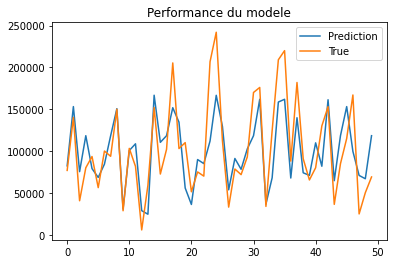

In [48]:
plt.title('Performance du modele')
plt.plot(list(prediction_3)[:50], label = 'Prediction')
plt.plot(list(y_val)[:50], label = 'True')
plt.legend()

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score
# mean_absolute_error()

In [ ]:
# r2_score()